In [1]:
from sklearn.metrics import root_mean_squared_error

import time

from auxfunctions import *
from implementations import *

import warnings
warnings.filterwarnings('ignore')

In [2]:
def rho_matern(d, nu_1, nu_2, nu_12, theta_1, theta_2, theta_12):
    return (theta_12**2/(theta_1*theta_2))**(d/2) * ( gamma(nu_1+d/2)*gamma(nu_2+d/2) / (gamma(nu_1)*gamma(nu_2)) )**(1/2) * gamma(nu_12)/gamma(nu_12+d/2)

In [39]:
d = 2
sup = 1

n = 1_000
n_test = 100

# $\nu_{1} = \nu_{2} = 1/2$

In [46]:
nu_1 = 1/2
nu_2 = 1/2

## $\theta_{1} = 2$, $\theta_{2} = 2.5$

In [40]:
theta_1 = 2
theta_2 = 2.5

In [41]:
nu_12 = ( nu_1 + nu_2 ) / 2
theta_12 = min(theta_1, theta_2)
rho_12 = rho_matern(d, nu_1, nu_2, nu_12, theta_1, theta_2, theta_12)
rho_12

0.8

In [ ]:
Ns = [2, 10, 100]
ns_clusters = [
    500, # 2
    100, # 10
    10,  # 100
]

rmses_NcoK_KM = []
rmses_NcoK_NN = []
rmses_coKNN = []

rmses_NcoK_KM_true = []
rmses_NcoK_NN_true = []
rmses_coKNN_true = []

times_NcoK_KM = []
times_NcoK_NN = []
times_coKNN = []

num_replications = 50

In [ ]:
for _ in range(num_replications):
    X_1 = gen_observation_points(d, n + n_test, sup)
    X_2 = gen_observation_points(d, n, sup)
    sigma = K(X_1, X_2, matern_model(theta_1, nu_1), matern_model(theta_2, nu_2), matern_model(theta_12, nu_12), rho_12)

    Y = np.linalg.cholesky(sigma) @ np.random.normal(0, 1, (2*n + n_test))
    Y_1, Y_2 = Y[:(n+n_test)], Y[(n+n_test):]
 
    X_test, Y_test = X_1[:n_test], Y_1[:n_test]
    X_1, Y_1 = X_1[n_test:], Y_1[n_test:]

    sigma = sigma[n_test:, :][:, n_test:]

# CO KRIGING
    Y_coK = co_kriging(X_test, X_1, X_2, Y_1, Y_2, matern_model(theta_1, nu_1), matern_model(theta_12, nu_12), rho_12, sigma)

# CO KRIGING NN
    rmse_aux, rmse_true_aux, time_aux = [], [], []
    for N in Ns:    
        start_time = time.time()
        coKNN = coKrigingNN(X_1, X_2, Y_1, Y_2, N, matern_model, theta_1, theta_2, 
                            theta_12, nu_1, nu_2, nu_12, rho_12)
        Y_pred = coKNN.predict(X_test)
        end_time = time.time()

        time_aux.append(end_time - start_time)
        rmse_aux.append(root_mean_squared_error(Y_coK, Y_pred))
        rmse_true_aux.append(root_mean_squared_error(Y_test, Y_pred))
    rmses_coKNN.append(rmse_aux)
    rmses_coKNN_true.append(rmse_true_aux)
    times_coKNN.append(time_aux)

# NESTED CO KRIGING
    rmse_aux, rmse_true_aux, time_aux = [[], []], [[], []], [[], []]
    for n_clusters in ns_clusters:
    # NcoK KM
        start_time = time.time()
        NcoK = NestedCoKriging(X_1, X_2, Y_1, Y_2, matern_model, 
                                theta_1, theta_2, theta_12, nu_1,
                                nu_2, nu_12, rho_12)
        A_1 = gen_A(X_1, n_clusters)
        A_2 = gen_A(X_2, n_clusters)
        Y_pred = NcoK.predict(X_test, A_1, A_2)
        end_time = time.time()
        
        time_aux[0].append(end_time-start_time)
        rmse_aux[0].append(root_mean_squared_error(Y_coK, Y_pred))
        rmse_true_aux[0].append(root_mean_squared_error(Y_test, Y_pred))

    # NcoK NN
        start_time = time.time()
        Y_pred = NcoK.predict(X_test, NN=True, n_clusters=n_clusters)
        end_time = time.time()

        time_aux[1].append(end_time-start_time)
        rmse_aux[1].append(root_mean_squared_error(Y_coK, Y_pred))
        rmse_true_aux[1].append(root_mean_squared_error(Y_test, Y_pred))

    rmses_NcoK_KM.append(rmse_aux[0])
    rmses_NcoK_KM_true.append(rmse_true_aux[0])
    times_NcoK_KM.append(time_aux[0])

    rmses_NcoK_NN.append(rmse_aux[1])
    rmses_NcoK_NN_true.append(rmse_true_aux[1])
    times_NcoK_NN.append(time_aux[1])
    
    print(f'{_} listo :)')

### Resultados RMSE vs CoK

In [ ]:
np.hstack([rmses_NcoK_KM, rmses_NcoK_NN, rmses_coKNN])

In [ ]:
plt.figure(figsize=(15,6))

plt.boxplot(np.hstack([rmses_NcoK_KM, rmses_NcoK_NN, rmses_coKNN]))

plt.xticks(range(1, 1 + 2*len(ns_clusters) + len(Ns)),
           [f'NcoK KM\n{n_clusters=}\nN={n//n_clusters}' for n_clusters in ns_clusters] + 
           [f'NcoK NN\n{n_clusters=}\nN={n//n_clusters}' for n_clusters in ns_clusters] + 
           [f'coKNN\n{N=}\n{N/n:.2%}' for N in Ns])

plt.ylabel('RMSE(CoKriging, Model)')
plt.title(f'{n=:_.0f}, {d=}, {nu_1=}, {nu_2=}, {theta_1=}, {theta_2=}');

### Resultados RMSE vs Y_true

In [ ]:
np.hstack([rmses_NcoK_KM_true, rmses_NcoK_NN_true, rmses_coKNN_true])

In [ ]:
plt.figure(figsize=(15,6))

plt.boxplot(np.hstack([rmses_NcoK_KM_true, rmses_NcoK_NN_true, rmses_coKNN_true]))

plt.xticks(range(1, 1 + 2*len(ns_clusters) + len(Ns)),
           [f'NcoK KM\n{n_clusters=}\nN={n//n_clusters}' for n_clusters in ns_clusters] + 
           [f'NcoK NN\n{n_clusters=}\nN={n//n_clusters}' for n_clusters in ns_clusters] + 
           [f'coKNN\n{N=}\n{N/n:.2%}' for N in Ns])

plt.ylabel('RMSE(Y_true, Model)')
plt.title(f'{n=:_.0f}, {d=}, {nu_1=}, {nu_2=}, {theta_1=}, {theta_2=}');

### Resultados Times

In [ ]:
np.hstack([times_NcoK_KM,times_NcoK_NN,times_coKNN])

In [ ]:
plt.figure(figsize=(15,6))

plt.boxplot(np.hstack([times_NcoK_KM,times_NcoK_NN,times_coKNN]))

plt.xticks(range(1, 1 + 2*len(ns_clusters) + len(Ns)),
           [f'NcoK KM\n{n_clusters=}\nN={n//n_clusters}' for n_clusters in ns_clusters] + 
           [f'NcoK NN\n{n_clusters=}\nN={n//n_clusters}' for n_clusters in ns_clusters] + 
           [f'coKNN\n{N=}\n{N/n:.2%}' for N in Ns])

plt.ylabel('Time [s]')
plt.title(f'{n=:_.0f}, {d=}, {nu_1=}, {nu_2=}, {theta_1=}, {theta_2=}');

## $\theta_{1} = 4$, $\theta_{2} = 5$

In [21]:
theta_1 = 4
theta_2 = 5

In [6]:
nu_12 = ( nu_1 + nu_2 ) / 2
theta_12 = min(theta_1, theta_2)
rho_12 = rho_matern(d, nu_1, nu_2, nu_12, theta_1, theta_2, theta_12)
rho_12

0.8

In [7]:
Ns = [2, 10, 100]
ns_clusters = [
    500, # 2
    100, # 10
    10,  # 100
]

rmses_NcoK_KM = []
rmses_NcoK_NN = []
rmses_coKNN = []

rmses_NcoK_KM_true = []
rmses_NcoK_NN_true = []
rmses_coKNN_true = []

times_NcoK_KM = []
times_NcoK_NN = []
times_coKNN = []

num_replications = 50

In [ ]:
for _ in range(num_replications):
    X_1 = gen_observation_points(d, n + n_test, sup)
    X_2 = gen_observation_points(d, n, sup)
    sigma = K(X_1, X_2, matern_model(theta_1, nu_1), matern_model(theta_2, nu_2), matern_model(theta_12, nu_12), rho_12)

    Y = np.linalg.cholesky(sigma) @ np.random.normal(0, 1, (2*n + n_test))
    Y_1, Y_2 = Y[:(n+n_test)], Y[(n+n_test):]
 
    X_test, Y_test = X_1[:n_test], Y_1[:n_test]
    X_1, Y_1 = X_1[n_test:], Y_1[n_test:]

    sigma = sigma[n_test:, :][:, n_test:]

# CO KRIGING
    Y_coK = co_kriging(X_test, X_1, X_2, Y_1, Y_2, matern_model(theta_1, nu_1), matern_model(theta_12, nu_12), rho_12, sigma)

# CO KRIGING NN
    rmse_aux, rmse_true_aux, time_aux = [], [], []
    for N in Ns:    
        start_time = time.time()
        coKNN = coKrigingNN(X_1, X_2, Y_1, Y_2, N, matern_model, theta_1, theta_2, 
                            theta_12, nu_1, nu_2, nu_12, rho_12)
        Y_pred = coKNN.predict(X_test)
        end_time = time.time()

        time_aux.append(end_time - start_time)
        rmse_aux.append(root_mean_squared_error(Y_coK, Y_pred))
        rmse_true_aux.append(root_mean_squared_error(Y_test, Y_pred))
    rmses_coKNN.append(rmse_aux)
    rmses_coKNN_true.append(rmse_true_aux)
    times_coKNN.append(time_aux)

# NESTED CO KRIGING
    rmse_aux, rmse_true_aux, time_aux = [[], []], [[], []], [[], []]
    for n_clusters in ns_clusters:
    # NcoK KM
        start_time = time.time()
        NcoK = NestedCoKriging(X_1, X_2, Y_1, Y_2, matern_model, 
                                theta_1, theta_2, theta_12, nu_1,
                                nu_2, nu_12, rho_12)
        A_1 = gen_A(X_1, n_clusters)
        A_2 = gen_A(X_2, n_clusters)
        Y_pred = NcoK.predict(X_test, A_1, A_2)
        end_time = time.time()
        
        time_aux[0].append(end_time-start_time)
        rmse_aux[0].append(root_mean_squared_error(Y_coK, Y_pred))
        rmse_true_aux[0].append(root_mean_squared_error(Y_test, Y_pred))

    # NcoK NN
        start_time = time.time()
        Y_pred = NcoK.predict(X_test, NN=True, n_clusters=n_clusters)
        end_time = time.time()

        time_aux[1].append(end_time-start_time)
        rmse_aux[1].append(root_mean_squared_error(Y_coK, Y_pred))
        rmse_true_aux[1].append(root_mean_squared_error(Y_test, Y_pred))

    rmses_NcoK_KM.append(rmse_aux[0])
    rmses_NcoK_KM_true.append(rmse_true_aux[0])
    times_NcoK_KM.append(time_aux[0])

    rmses_NcoK_NN.append(rmse_aux[1])
    rmses_NcoK_NN_true.append(rmse_true_aux[1])
    times_NcoK_NN.append(time_aux[1])
    
    print(f'{_} listo :)')
# 1274m 48.3s

### Resultados RMSE vs CoK

In [9]:
np.hstack([rmses_NcoK_KM, rmses_NcoK_NN, rmses_coKNN])

array([[0.03185998, 0.0620989 , 0.06175665, 0.08331144, 0.02981375,
        0.000732  , 0.1401896 , 0.03277806, 0.00074711],
       [0.03663946, 0.06351723, 0.07049324, 0.09165939, 0.02792917,
        0.00061588, 0.16503871, 0.03229247, 0.00074246],
       [0.03077911, 0.05437974, 0.08144265, 0.07670429, 0.03683485,
        0.00112324, 0.14727529, 0.0390771 , 0.00113348],
       [0.03493717, 0.0692907 , 0.07915847, 0.08185348, 0.03050282,
        0.00069022, 0.16528247, 0.03275916, 0.00068194],
       [0.04019245, 0.06146176, 0.06598318, 0.07727887, 0.02503792,
        0.00045264, 0.13292485, 0.03097026, 0.00049285],
       [0.03623677, 0.07653347, 0.08319657, 0.0909598 , 0.02453747,
        0.00062885, 0.13230656, 0.02680312, 0.00063369],
       [0.03773185, 0.0605779 , 0.07056233, 0.08131479, 0.02684087,
        0.00057707, 0.15017068, 0.03030181, 0.00061912],
       [0.04089816, 0.07084965, 0.07771308, 0.07559024, 0.02985929,
        0.00077354, 0.123691  , 0.03389654, 0.00080274],


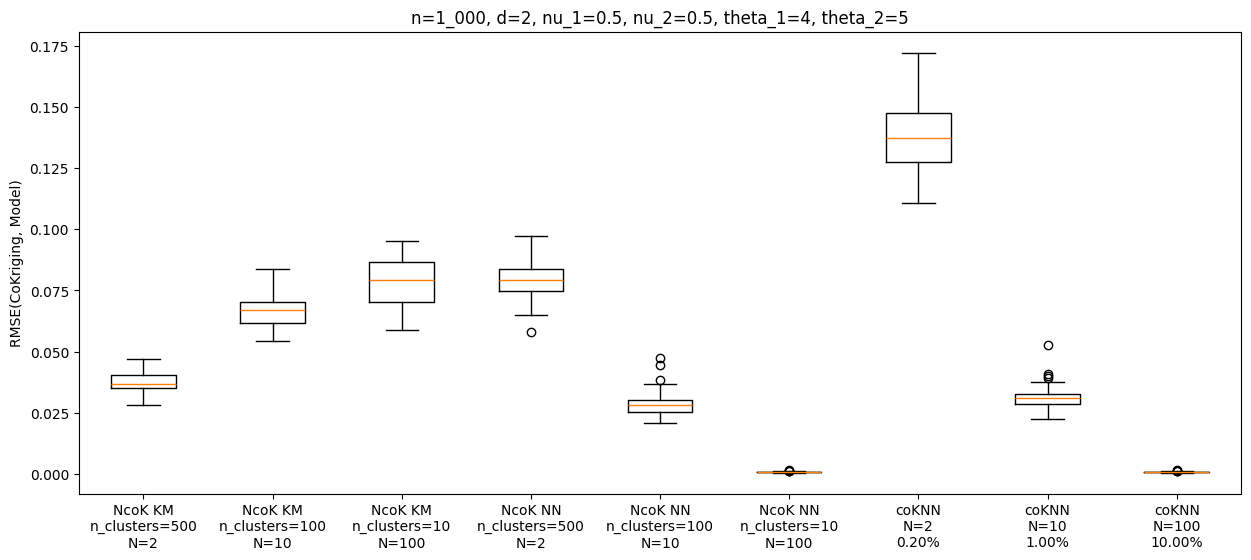

In [22]:
plt.figure(figsize=(15,6))

plt.boxplot(np.hstack([rmses_NcoK_KM, rmses_NcoK_NN, rmses_coKNN]))

plt.xticks(range(1, 1 + 2*len(ns_clusters) + len(Ns)),
           [f'NcoK KM\n{n_clusters=}\nN={n//n_clusters}' for n_clusters in ns_clusters] + 
           [f'NcoK NN\n{n_clusters=}\nN={n//n_clusters}' for n_clusters in ns_clusters] + 
           [f'coKNN\n{N=}\n{N/n:.2%}' for N in Ns])

plt.ylabel('RMSE(CoKriging, Model)')
plt.title(f'{n=:_.0f}, {d=}, {nu_1=}, {nu_2=}, {theta_1=}, {theta_2=}');

### Resultados RMSE vs Y_true

In [11]:
np.hstack([rmses_NcoK_KM_true, rmses_NcoK_NN_true, rmses_coKNN_true])

array([[0.25314375, 0.24572582, 0.25605   , 0.26278014, 0.25303863,
        0.24380243, 0.29198853, 0.25196892, 0.2437774 ],
       [0.23806196, 0.24516075, 0.24510379, 0.24778977, 0.23772005,
        0.23473951, 0.28451153, 0.24155226, 0.23477438],
       [0.24659265, 0.23866643, 0.24678796, 0.25289401, 0.24334338,
        0.24487402, 0.28587409, 0.24165147, 0.24485341],
       [0.22810743, 0.24149449, 0.23797093, 0.24268888, 0.22876496,
        0.22253954, 0.28231315, 0.23113257, 0.22255858],
       [0.23324664, 0.23479746, 0.23837394, 0.24349804, 0.23036895,
        0.23507465, 0.26212133, 0.23232441, 0.2350684 ],
       [0.21078094, 0.21719188, 0.21541797, 0.21349313, 0.21070852,
        0.2098283 , 0.24720296, 0.21096906, 0.20980522],
       [0.27913118, 0.28516657, 0.29011211, 0.29833291, 0.28075133,
        0.27990309, 0.32524532, 0.28140099, 0.2798887 ],
       [0.27630355, 0.27635136, 0.29506632, 0.28834385, 0.27038795,
        0.26938524, 0.29722848, 0.26964119, 0.26940478],


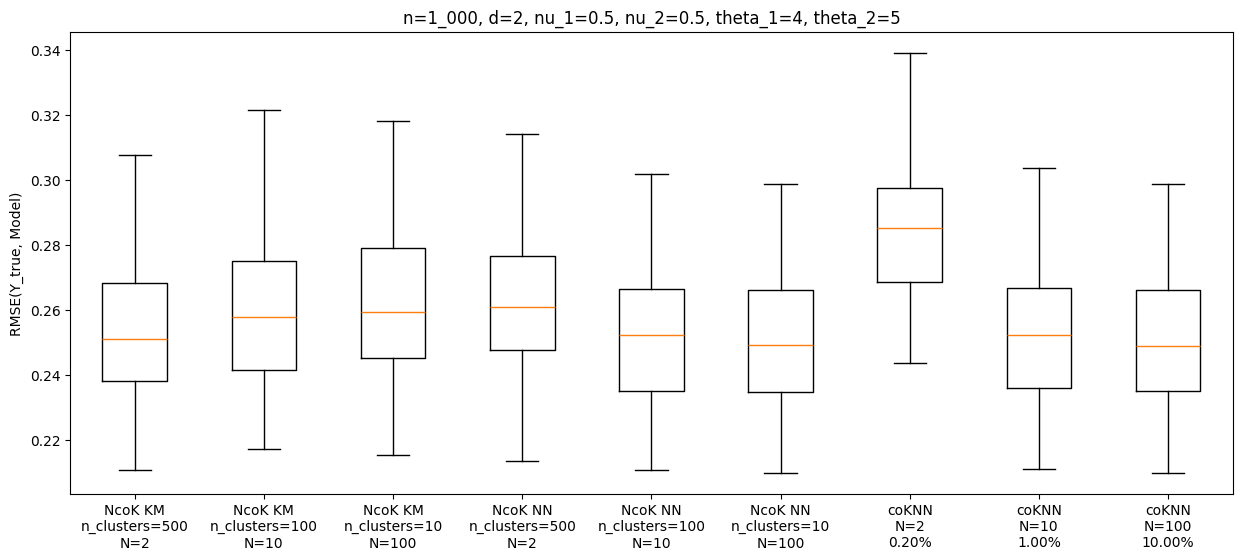

In [23]:
plt.figure(figsize=(15,6))

plt.boxplot(np.hstack([rmses_NcoK_KM_true, rmses_NcoK_NN_true, rmses_coKNN_true]))

plt.xticks(range(1, 1 + 2*len(ns_clusters) + len(Ns)),
           [f'NcoK KM\n{n_clusters=}\nN={n//n_clusters}' for n_clusters in ns_clusters] + 
           [f'NcoK NN\n{n_clusters=}\nN={n//n_clusters}' for n_clusters in ns_clusters] + 
           [f'coKNN\n{N=}\n{N/n:.2%}' for N in Ns])

plt.ylabel('RMSE(Y_true, Model)')
plt.title(f'{n=:_.0f}, {d=}, {nu_1=}, {nu_2=}, {theta_1=}, {theta_2=}');

### Resultados Times

In [13]:
np.hstack([times_NcoK_KM,times_NcoK_NN,times_coKNN])

array([[2.50187628e+01, 2.89991450e+00, 3.65001607e+00, 1.46365221e+03,
        6.74835649e+01, 9.26742387e+00, 3.78580093e-02, 8.63811970e-02,
        2.63550615e+00],
       [1.95001099e+01, 2.92347670e+00, 3.78328109e+00, 1.46579796e+03,
        6.78502269e+01, 9.41790080e+00, 3.35302353e-02, 5.52599430e-02,
        4.61072683e-01],
       [1.92003872e+01, 2.95212507e+00, 3.81640840e+00, 1.40577187e+03,
        6.59973602e+01, 9.81665707e+00, 1.63655281e-02, 6.01246357e-02,
        4.72677946e-01],
       [1.92005470e+01, 2.98811173e+00, 3.78322554e+00, 1.42423854e+03,
        6.81609182e+01, 9.43334889e+00, 3.35652828e-02, 3.28857899e-02,
        4.66695786e-01],
       [1.93138137e+01, 2.82248259e+00, 3.63176656e+00, 1.41774030e+03,
        6.68782563e+01, 9.31659293e+00, 3.28128338e-02, 4.54785824e-02,
        5.22253990e-01],
       [1.92193341e+01, 2.90001035e+00, 3.73821855e+00, 1.42865421e+03,
        6.66832714e+01, 9.44502187e+00, 2.67615318e-02, 3.43687534e-02,
        3.8

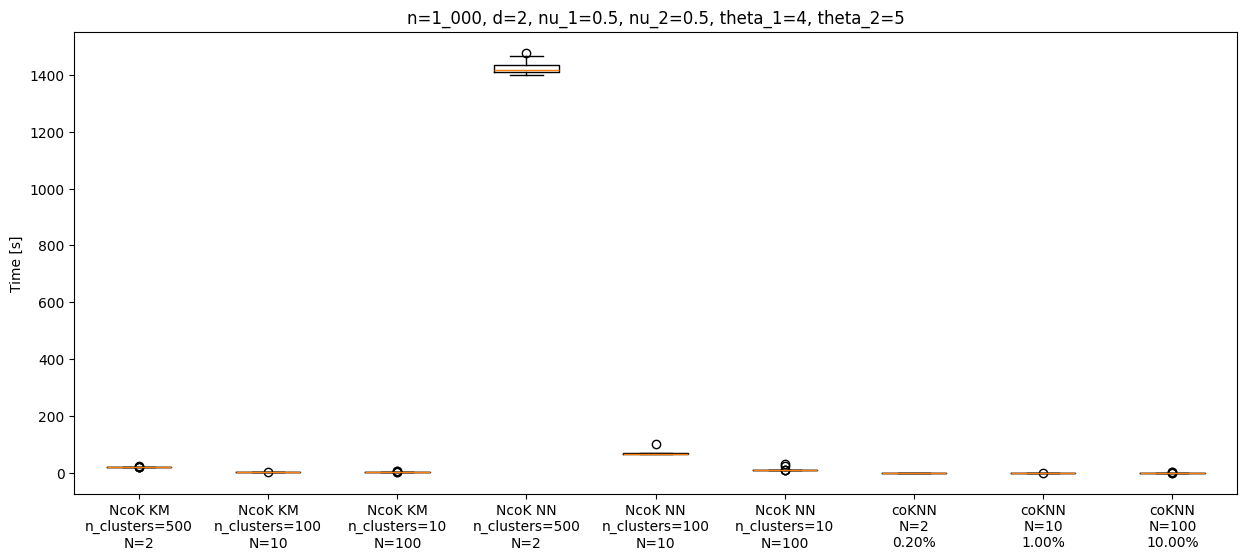

In [24]:
plt.figure(figsize=(15,6))

plt.boxplot(np.hstack([times_NcoK_KM,times_NcoK_NN,times_coKNN]))

plt.xticks(range(1, 1 + 2*len(ns_clusters) + len(Ns)),
           [f'NcoK KM\n{n_clusters=}\nN={n//n_clusters}' for n_clusters in ns_clusters] + 
           [f'NcoK NN\n{n_clusters=}\nN={n//n_clusters}' for n_clusters in ns_clusters] + 
           [f'coKNN\n{N=}\n{N/n:.2%}' for N in Ns])

plt.ylabel('Time [s]')
plt.title(f'{n=:_.0f}, {d=}, {nu_1=}, {nu_2=}, {theta_1=}, {theta_2=}');

# $\theta_1 = 4$, $\theta_2 = 5$

In [43]:
theta_1 = 4
theta_2 = 5

## $\nu_{1} = 1/2, \nu_{2} = 5/2$

In [44]:
nu_1 = 1/2
nu_2 = 5/2

In [ ]:
nu_12 = ( nu_1 + nu_2 ) / 2
theta_12 = min(theta_1, theta_2)
rho_12 = rho_matern(d, nu_1, nu_2, nu_12, theta_1, theta_2, theta_12)
rho_12

In [ ]:
Ns = [2, 10, 100]
ns_clusters = [
    500, # 2
    100, # 10
    10,  # 100
]

rmses_NcoK_KM = []
rmses_NcoK_NN = []
rmses_coKNN = []

rmses_NcoK_KM_true = []
rmses_NcoK_NN_true = []
rmses_coKNN_true = []

times_NcoK_KM = []
times_NcoK_NN = []
times_coKNN = []

num_replications = 50

In [ ]:
for _ in range(num_replications):
    X_1 = gen_observation_points(d, n + n_test, sup)
    X_2 = gen_observation_points(d, n, sup)
    sigma = K(X_1, X_2, matern_model(theta_1, nu_1), matern_model(theta_2, nu_2), matern_model(theta_12, nu_12), rho_12)

    Y = np.linalg.cholesky(sigma) @ np.random.normal(0, 1, (2*n + n_test))
    Y_1, Y_2 = Y[:(n+n_test)], Y[(n+n_test):]
 
    X_test, Y_test = X_1[:n_test], Y_1[:n_test]
    X_1, Y_1 = X_1[n_test:], Y_1[n_test:]

    sigma = sigma[n_test:, :][:, n_test:]

# CO KRIGING
    Y_coK = co_kriging(X_test, X_1, X_2, Y_1, Y_2, matern_model(theta_1, nu_1), matern_model(theta_12, nu_12), rho_12, sigma)

# CO KRIGING NN
    rmse_aux, rmse_true_aux, time_aux = [], [], []
    for N in Ns:    
        start_time = time.time()
        coKNN = coKrigingNN(X_1, X_2, Y_1, Y_2, N, matern_model, theta_1, theta_2, 
                            theta_12, nu_1, nu_2, nu_12, rho_12)
        Y_pred = coKNN.predict(X_test)
        end_time = time.time()

        time_aux.append(end_time - start_time)
        rmse_aux.append(root_mean_squared_error(Y_coK, Y_pred))
        rmse_true_aux.append(root_mean_squared_error(Y_test, Y_pred))
    rmses_coKNN.append(rmse_aux)
    rmses_coKNN_true.append(rmse_true_aux)
    times_coKNN.append(time_aux)

# NESTED CO KRIGING
    rmse_aux, rmse_true_aux, time_aux = [[], []], [[], []], [[], []]
    for n_clusters in ns_clusters:
    # NcoK KM
        start_time = time.time()
        NcoK = NestedCoKriging(X_1, X_2, Y_1, Y_2, matern_model, 
                                theta_1, theta_2, theta_12, nu_1,
                                nu_2, nu_12, rho_12)
        A_1 = gen_A(X_1, n_clusters)
        A_2 = gen_A(X_2, n_clusters)
        Y_pred = NcoK.predict(X_test, A_1, A_2)
        end_time = time.time()
        
        time_aux[0].append(end_time-start_time)
        rmse_aux[0].append(root_mean_squared_error(Y_coK, Y_pred))
        rmse_true_aux[0].append(root_mean_squared_error(Y_test, Y_pred))

    # NcoK NN
        start_time = time.time()
        Y_pred = NcoK.predict(X_test, NN=True, n_clusters=n_clusters)
        end_time = time.time()

        time_aux[1].append(end_time-start_time)
        rmse_aux[1].append(root_mean_squared_error(Y_coK, Y_pred))
        rmse_true_aux[1].append(root_mean_squared_error(Y_test, Y_pred))

    rmses_NcoK_KM.append(rmse_aux[0])
    rmses_NcoK_KM_true.append(rmse_true_aux[0])
    times_NcoK_KM.append(time_aux[0])

    rmses_NcoK_NN.append(rmse_aux[1])
    rmses_NcoK_NN_true.append(rmse_true_aux[1])
    times_NcoK_NN.append(time_aux[1])
    
    print(f'{_} listo :)')

### Resultados RMSE vs CoK

In [ ]:
np.hstack([rmses_NcoK_KM, rmses_NcoK_NN, rmses_coKNN])

In [ ]:
plt.figure(figsize=(15,6))

plt.boxplot(np.hstack([rmses_NcoK_KM, rmses_NcoK_NN, rmses_coKNN]))

plt.xticks(range(1, 1 + 2*len(ns_clusters) + len(Ns)),
           [f'NcoK KM\n{n_clusters=}\nN={n//n_clusters}' for n_clusters in ns_clusters] + 
           [f'NcoK NN\n{n_clusters=}\nN={n//n_clusters}' for n_clusters in ns_clusters] + 
           [f'coKNN\n{N=}\n{N/n:.2%}' for N in Ns])

plt.ylabel('RMSE(CoKriging, Model)')
plt.title(f'{n=:_.0f}, {d=}, {nu_1=}, {nu_2=}, {theta_1=}, {theta_2=}');

### Resultados RMSE vs Y_true

In [ ]:
np.hstack([rmses_NcoK_KM_true, rmses_NcoK_NN_true, rmses_coKNN_true])

In [ ]:
plt.figure(figsize=(15,6))

plt.boxplot(np.hstack([rmses_NcoK_KM_true, rmses_NcoK_NN_true, rmses_coKNN_true]))

plt.xticks(range(1, 1 + 2*len(ns_clusters) + len(Ns)),
           [f'NcoK KM\n{n_clusters=}\nN={n//n_clusters}' for n_clusters in ns_clusters] + 
           [f'NcoK NN\n{n_clusters=}\nN={n//n_clusters}' for n_clusters in ns_clusters] + 
           [f'coKNN\n{N=}\n{N/n:.2%}' for N in Ns])

plt.ylabel('RMSE(Y_true, Model)')
plt.title(f'{n=:_.0f}, {d=}, {nu_1=}, {nu_2=}, {theta_1=}, {theta_2=}');

### Resultados Times

In [ ]:
np.hstack([times_NcoK_KM,times_NcoK_NN,times_coKNN])

In [ ]:
plt.figure(figsize=(15,6))

plt.boxplot(np.hstack([times_NcoK_KM,times_NcoK_NN,times_coKNN]))

plt.xticks(range(1, 1 + 2*len(ns_clusters) + len(Ns)),
           [f'NcoK KM\n{n_clusters=}\nN={n//n_clusters}' for n_clusters in ns_clusters] + 
           [f'NcoK NN\n{n_clusters=}\nN={n//n_clusters}' for n_clusters in ns_clusters] + 
           [f'coKNN\n{N=}\n{N/n:.2%}' for N in Ns])

plt.ylabel('Time [s]')
plt.title(f'{n=:_.0f}, {d=}, {nu_1=}, {nu_2=}, {theta_1=}, {theta_2=}');

## $\nu_{1} = 5/2, \nu_{2} = 1/2$

In [ ]:
nu_1 = 5/2
nu_2 = 1/2

In [ ]:
nu_12 = ( nu_1 + nu_2 ) / 2
theta_12 = min(theta_1, theta_2)
rho_12 = rho_matern(d, nu_1, nu_2, nu_12, theta_1, theta_2, theta_12)
rho_12

In [ ]:
Ns = [2, 10, 100]
ns_clusters = [
    500, # 2
    100, # 10
    10,  # 100
]

rmses_NcoK_KM = []
rmses_NcoK_NN = []
rmses_coKNN = []

rmses_NcoK_KM_true = []
rmses_NcoK_NN_true = []
rmses_coKNN_true = []

times_NcoK_KM = []
times_NcoK_NN = []
times_coKNN = []

num_replications = 50

In [ ]:
for _ in range(num_replications):
    X_1 = gen_observation_points(d, n + n_test, sup)
    X_2 = gen_observation_points(d, n, sup)
    sigma = K(X_1, X_2, matern_model(theta_1, nu_1), matern_model(theta_2, nu_2), matern_model(theta_12, nu_12), rho_12)

    Y = np.linalg.cholesky(sigma) @ np.random.normal(0, 1, (2*n + n_test))
    Y_1, Y_2 = Y[:(n+n_test)], Y[(n+n_test):]
 
    X_test, Y_test = X_1[:n_test], Y_1[:n_test]
    X_1, Y_1 = X_1[n_test:], Y_1[n_test:]

    sigma = sigma[n_test:, :][:, n_test:]

# CO KRIGING
    Y_coK = co_kriging(X_test, X_1, X_2, Y_1, Y_2, matern_model(theta_1, nu_1), matern_model(theta_12, nu_12), rho_12, sigma)

# CO KRIGING NN
    rmse_aux, rmse_true_aux, time_aux = [], [], []
    for N in Ns:    
        start_time = time.time()
        coKNN = coKrigingNN(X_1, X_2, Y_1, Y_2, N, matern_model, theta_1, theta_2, 
                            theta_12, nu_1, nu_2, nu_12, rho_12)
        Y_pred = coKNN.predict(X_test)
        end_time = time.time()

        time_aux.append(end_time - start_time)
        rmse_aux.append(root_mean_squared_error(Y_coK, Y_pred))
        rmse_true_aux.append(root_mean_squared_error(Y_test, Y_pred))
    rmses_coKNN.append(rmse_aux)
    rmses_coKNN_true.append(rmse_true_aux)
    times_coKNN.append(time_aux)

# NESTED CO KRIGING
    rmse_aux, rmse_true_aux, time_aux = [[], []], [[], []], [[], []]
    for n_clusters in ns_clusters:
    # NcoK KM
        start_time = time.time()
        NcoK = NestedCoKriging(X_1, X_2, Y_1, Y_2, matern_model, 
                                theta_1, theta_2, theta_12, nu_1,
                                nu_2, nu_12, rho_12)
        A_1 = gen_A(X_1, n_clusters)
        A_2 = gen_A(X_2, n_clusters)
        Y_pred = NcoK.predict(X_test, A_1, A_2)
        end_time = time.time()
        
        time_aux[0].append(end_time-start_time)
        rmse_aux[0].append(root_mean_squared_error(Y_coK, Y_pred))
        rmse_true_aux[0].append(root_mean_squared_error(Y_test, Y_pred))

    # NcoK NN
        start_time = time.time()
        Y_pred = NcoK.predict(X_test, NN=True, n_clusters=n_clusters)
        end_time = time.time()

        time_aux[1].append(end_time-start_time)
        rmse_aux[1].append(root_mean_squared_error(Y_coK, Y_pred))
        rmse_true_aux[1].append(root_mean_squared_error(Y_test, Y_pred))

    rmses_NcoK_KM.append(rmse_aux[0])
    rmses_NcoK_KM_true.append(rmse_true_aux[0])
    times_NcoK_KM.append(time_aux[0])

    rmses_NcoK_NN.append(rmse_aux[1])
    rmses_NcoK_NN_true.append(rmse_true_aux[1])
    times_NcoK_NN.append(time_aux[1])
    
    print(f'{_} listo :)')

### Resultados RMSE vs CoK

In [ ]:
np.hstack([rmses_NcoK_KM, rmses_NcoK_NN, rmses_coKNN])

In [ ]:
plt.figure(figsize=(15,6))

plt.boxplot(np.hstack([rmses_NcoK_KM, rmses_NcoK_NN, rmses_coKNN]))

plt.xticks(range(1, 1 + 2*len(ns_clusters) + len(Ns)),
           [f'NcoK KM\n{n_clusters=}\nN={n//n_clusters}' for n_clusters in ns_clusters] + 
           [f'NcoK NN\n{n_clusters=}\nN={n//n_clusters}' for n_clusters in ns_clusters] + 
           [f'coKNN\n{N=}\n{N/n:.2%}' for N in Ns])

plt.ylabel('RMSE(CoKriging, Model)')
plt.title(f'{n=:_.0f}, {d=}, {nu_1=}, {nu_2=}, {theta_1=}, {theta_2=}');

### Resultados RMSE vs Y_true

In [ ]:
np.hstack([rmses_NcoK_KM_true, rmses_NcoK_NN_true, rmses_coKNN_true])

In [ ]:
plt.figure(figsize=(15,6))

plt.boxplot(np.hstack([rmses_NcoK_KM_true, rmses_NcoK_NN_true, rmses_coKNN_true]))

plt.xticks(range(1, 1 + 2*len(ns_clusters) + len(Ns)),
           [f'NcoK KM\n{n_clusters=}\nN={n//n_clusters}' for n_clusters in ns_clusters] + 
           [f'NcoK NN\n{n_clusters=}\nN={n//n_clusters}' for n_clusters in ns_clusters] + 
           [f'coKNN\n{N=}\n{N/n:.2%}' for N in Ns])

plt.ylabel('RMSE(Y_true, Model)')
plt.title(f'{n=:_.0f}, {d=}, {nu_1=}, {nu_2=}, {theta_1=}, {theta_2=}');

### Resultados Times

In [ ]:
np.hstack([times_NcoK_KM,times_NcoK_NN,times_coKNN])

In [ ]:
plt.figure(figsize=(15,6))

plt.boxplot(np.hstack([times_NcoK_KM,times_NcoK_NN,times_coKNN]))

plt.xticks(range(1, 1 + 2*len(ns_clusters) + len(Ns)),
           [f'NcoK KM\n{n_clusters=}\nN={n//n_clusters}' for n_clusters in ns_clusters] + 
           [f'NcoK NN\n{n_clusters=}\nN={n//n_clusters}' for n_clusters in ns_clusters] + 
           [f'coKNN\n{N=}\n{N/n:.2%}' for N in Ns])

plt.ylabel('Time [s]')
plt.title(f'{n=:_.0f}, {d=}, {nu_1=}, {nu_2=}, {theta_1=}, {theta_2=}');

## $\nu_{1} = 5/2, \nu_{2} = 5/2$

In [ ]:
nu_1 = 5/2
nu_2 = 5/2

In [ ]:
nu_12 = ( nu_1 + nu_2 ) / 2
theta_12 = min(theta_1, theta_2)
rho_12 = rho_matern(d, nu_1, nu_2, nu_12, theta_1, theta_2, theta_12)
rho_12

In [ ]:
Ns = [2, 10, 100]
ns_clusters = [
    500, # 2
    100, # 10
    10,  # 100
]

rmses_NcoK_KM = []
rmses_NcoK_NN = []
rmses_coKNN = []

rmses_NcoK_KM_true = []
rmses_NcoK_NN_true = []
rmses_coKNN_true = []

times_NcoK_KM = []
times_NcoK_NN = []
times_coKNN = []

num_replications = 50

In [ ]:
for _ in range(num_replications):
    X_1 = gen_observation_points(d, n + n_test, sup)
    X_2 = gen_observation_points(d, n, sup)
    sigma = K(X_1, X_2, matern_model(theta_1, nu_1), matern_model(theta_2, nu_2), matern_model(theta_12, nu_12), rho_12)

    Y = np.linalg.cholesky(sigma) @ np.random.normal(0, 1, (2*n + n_test))
    Y_1, Y_2 = Y[:(n+n_test)], Y[(n+n_test):]
 
    X_test, Y_test = X_1[:n_test], Y_1[:n_test]
    X_1, Y_1 = X_1[n_test:], Y_1[n_test:]

    sigma = sigma[n_test:, :][:, n_test:]

# CO KRIGING
    Y_coK = co_kriging(X_test, X_1, X_2, Y_1, Y_2, matern_model(theta_1, nu_1), matern_model(theta_12, nu_12), rho_12, sigma)

# CO KRIGING NN
    rmse_aux, rmse_true_aux, time_aux = [], [], []
    for N in Ns:    
        start_time = time.time()
        coKNN = coKrigingNN(X_1, X_2, Y_1, Y_2, N, matern_model, theta_1, theta_2, 
                            theta_12, nu_1, nu_2, nu_12, rho_12)
        Y_pred = coKNN.predict(X_test)
        end_time = time.time()

        time_aux.append(end_time - start_time)
        rmse_aux.append(root_mean_squared_error(Y_coK, Y_pred))
        rmse_true_aux.append(root_mean_squared_error(Y_test, Y_pred))
    rmses_coKNN.append(rmse_aux)
    rmses_coKNN_true.append(rmse_true_aux)
    times_coKNN.append(time_aux)

# NESTED CO KRIGING
    rmse_aux, rmse_true_aux, time_aux = [[], []], [[], []], [[], []]
    for n_clusters in ns_clusters:
    # NcoK KM
        start_time = time.time()
        NcoK = NestedCoKriging(X_1, X_2, Y_1, Y_2, matern_model, 
                                theta_1, theta_2, theta_12, nu_1,
                                nu_2, nu_12, rho_12)
        A_1 = gen_A(X_1, n_clusters)
        A_2 = gen_A(X_2, n_clusters)
        Y_pred = NcoK.predict(X_test, A_1, A_2)
        end_time = time.time()
        
        time_aux[0].append(end_time-start_time)
        rmse_aux[0].append(root_mean_squared_error(Y_coK, Y_pred))
        rmse_true_aux[0].append(root_mean_squared_error(Y_test, Y_pred))

    # NcoK NN
        start_time = time.time()
        Y_pred = NcoK.predict(X_test, NN=True, n_clusters=n_clusters)
        end_time = time.time()

        time_aux[1].append(end_time-start_time)
        rmse_aux[1].append(root_mean_squared_error(Y_coK, Y_pred))
        rmse_true_aux[1].append(root_mean_squared_error(Y_test, Y_pred))

    rmses_NcoK_KM.append(rmse_aux[0])
    rmses_NcoK_KM_true.append(rmse_true_aux[0])
    times_NcoK_KM.append(time_aux[0])

    rmses_NcoK_NN.append(rmse_aux[1])
    rmses_NcoK_NN_true.append(rmse_true_aux[1])
    times_NcoK_NN.append(time_aux[1])
    
    print(f'{_} listo :)')

### Resultados RMSE vs CoK

In [ ]:
np.hstack([rmses_NcoK_KM, rmses_NcoK_NN, rmses_coKNN])

In [ ]:
plt.figure(figsize=(15,6))

plt.boxplot(np.hstack([rmses_NcoK_KM, rmses_NcoK_NN, rmses_coKNN]))

plt.xticks(range(1, 1 + 2*len(ns_clusters) + len(Ns)),
           [f'NcoK KM\n{n_clusters=}\nN={n//n_clusters}' for n_clusters in ns_clusters] + 
           [f'NcoK NN\n{n_clusters=}\nN={n//n_clusters}' for n_clusters in ns_clusters] + 
           [f'coKNN\n{N=}\n{N/n:.2%}' for N in Ns])

plt.ylabel('RMSE(CoKriging, Model)')
plt.title(f'{n=:_.0f}, {d=}, {nu_1=}, {nu_2=}, {theta_1=}, {theta_2=}');

### Resultados RMSE vs Y_true

In [ ]:
np.hstack([rmses_NcoK_KM_true, rmses_NcoK_NN_true, rmses_coKNN_true])

In [ ]:
plt.figure(figsize=(15,6))

plt.boxplot(np.hstack([rmses_NcoK_KM_true, rmses_NcoK_NN_true, rmses_coKNN_true]))

plt.xticks(range(1, 1 + 2*len(ns_clusters) + len(Ns)),
           [f'NcoK KM\n{n_clusters=}\nN={n//n_clusters}' for n_clusters in ns_clusters] + 
           [f'NcoK NN\n{n_clusters=}\nN={n//n_clusters}' for n_clusters in ns_clusters] + 
           [f'coKNN\n{N=}\n{N/n:.2%}' for N in Ns])

plt.ylabel('RMSE(Y_true, Model)')
plt.title(f'{n=:_.0f}, {d=}, {nu_1=}, {nu_2=}, {theta_1=}, {theta_2=}');

### Resultados Times

In [ ]:
np.hstack([times_NcoK_KM,times_NcoK_NN,times_coKNN])

In [ ]:
plt.figure(figsize=(15,6))

plt.boxplot(np.hstack([times_NcoK_KM,times_NcoK_NN,times_coKNN]))

plt.xticks(range(1, 1 + 2*len(ns_clusters) + len(Ns)),
           [f'NcoK KM\n{n_clusters=}\nN={n//n_clusters}' for n_clusters in ns_clusters] + 
           [f'NcoK NN\n{n_clusters=}\nN={n//n_clusters}' for n_clusters in ns_clusters] + 
           [f'coKNN\n{N=}\n{N/n:.2%}' for N in Ns])

plt.ylabel('Time [s]')
plt.title(f'{n=:_.0f}, {d=}, {nu_1=}, {nu_2=}, {theta_1=}, {theta_2=}');